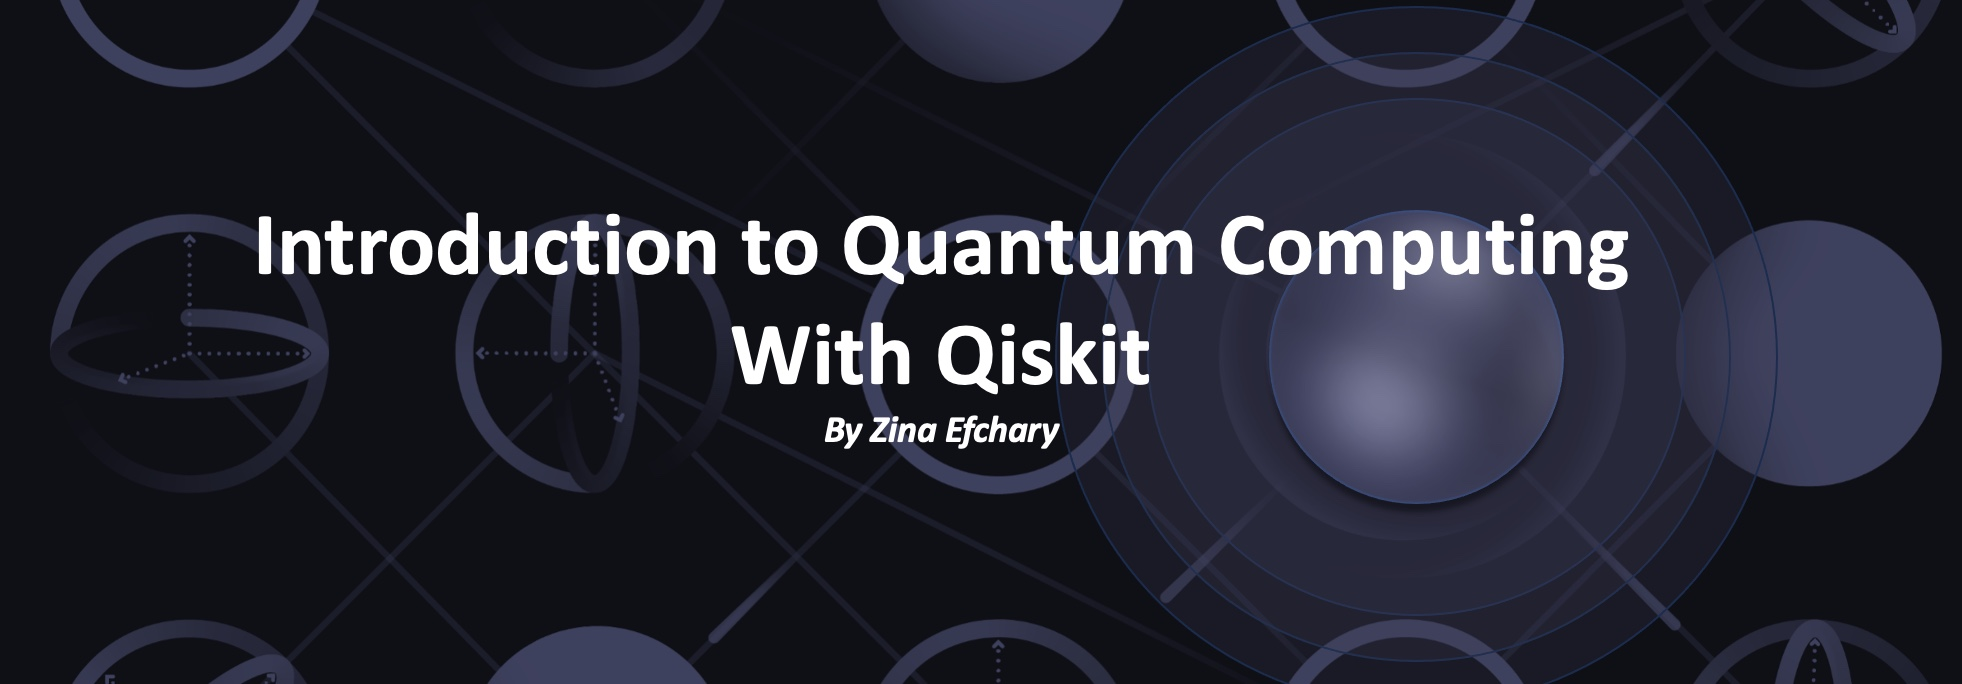


# Table of Contents
- **[Part I: Introduction to Quantum Circuits & Quantum Gates](#Intro)**
    - **[Exercise 1: build your first circuit](#exercise1)**
- **[Part II: Let's Create Entanglements!](#Entanglements)**
    - **[Exercise 2: create simple Bell-States](#exercise2)**
    - **[Exercise 3: create GHZ-States](#exercise2)**
- **[Part III: Circuit Depth & Optimization](#CircuitDepth)**
    - **[Exercise 4: compute the depth of your circuit](#exercise4)**
    - **[Exercise 5 (Challenge): minimize your circuit depth](#exercise5)**

In [22]:
# Importing standard Qiskit libraries
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
statevector_backend = Aer.get_backend('statevector_simulator') # setting the simulator and backend
sim_backend = Aer.get_backend('aer_simulator')

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

<a id="Intro"></a>
## 1. Introduction to Quantum Circuits & Quantum Gates

A quantum bit or *qubit* is the fundamental unit of quantum information, whereas a *quantum circuit* is the fundamental unit of computation. Quantum circuits are sets of quantum gate operations on qubits and allow manipulation of quantum states. Runing a quantum circuit means applying gate operations consecutively.
Now, let's meet some of them.

### Basic single qubit gates

The single qubit gates $\textbf{X}$, $\textbf{Y}$, $\textbf{Z}$ perform a $180^{\circ}$ rotation of the state around the corresponding axis.

The $\textbf{H}$ (Hadamard) gate can be used to create an equal superposition between the $|0\rangle$ and $|1\rangle$ state.





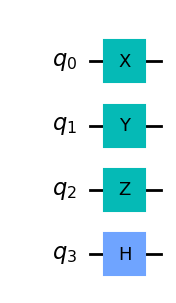

In [59]:
qc = QuantumCircuit(4) # creating a quantum circuit (qc) with 4 qubits

qc.x(0) # applying an x-gate on qubit 0
qc.y(1) # applying an y-gate on qubit 1
qc.z(2) # applying an z-gate on qubit 2
qc.h(3) # applying an h-gate on qubit 3

qc.draw('mpl') # plotting the quantum circuit

Now let's plot the statevector of each qubit and see how each gate changes the initial state of their qubit. Note all the qubits are initialised in the $|0\rangle$ state.

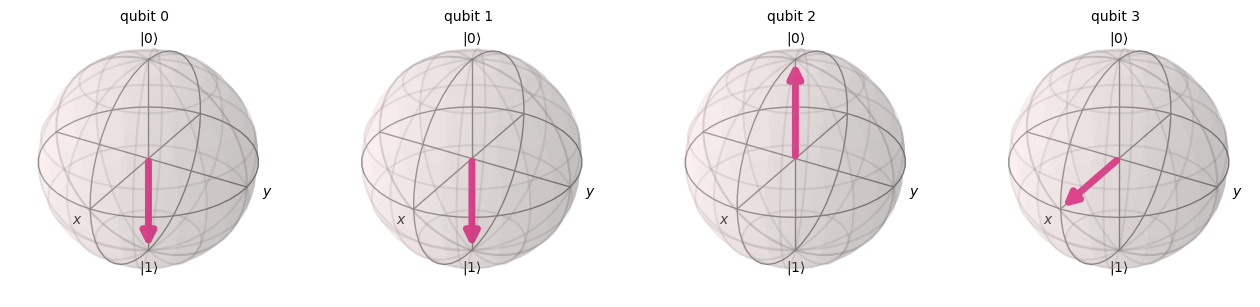

In [60]:
state = statevector_backend.run(qc).result().get_statevector()
plot_bloch_multivector(state)

We can see that $\textbf{X}$ gate rotated the statevectot of qubit 0 by $180^{\circ}$ around the x-axis, and the $\textbf{Y}$ gate rotated qubit 1 by $180^{\circ}$ around the y-axis, with both landing in the $|1\rangle$ state. The $\textbf{Z}$ gate did not make any changes to the state of qubit 2 since it lay on the z-axis already. The $\textbf{H}$ (Hadamard) gate created an equal superposition between the $|0\rangle$ and $|1\rangle$ state in qubit 3. 

Now let's measure all the qubits and plot the (quasi) distribution.

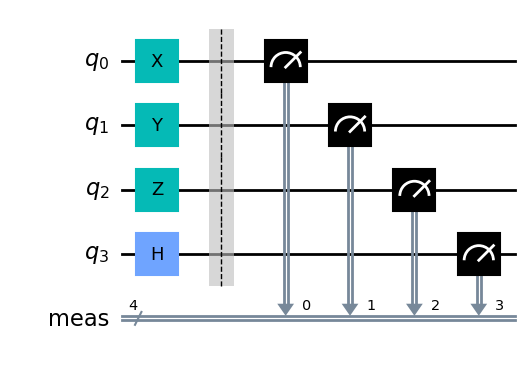

In [61]:
qc.measure_all() # this maps the measurement results of the qubits to classical bits.
qc.draw('mpl')


{'0011': 505, '1011': 519}


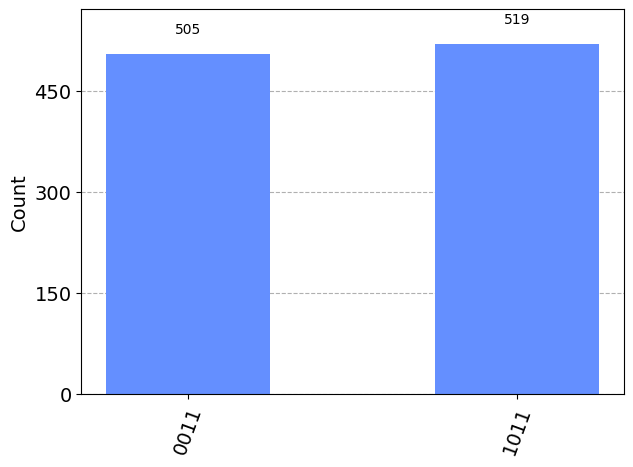

In [39]:
counts = sim_backend.run(qc,shots=1024).result().get_counts() # we need to perform multiple measurements, shots determine how often we measure
print(counts)
plot_histogram(counts)



Check your Understanding: Can you explain why we have two different possible results? What do the number of counts tell us about the probability of measuring each state?

### Multi qubit gates (controlled gates)

Controlled gates in quantum computing are gates that perform a specific transformation on a target qubit, but the operation is conditioned on the state of one or more control qubits. If the control qubits are in a certain state, the gate is applied to the target qubit, otherwise, it is not. These gates act as switches, allowing for selective operations based on the state of the control qubits. Controlled gates are important building blocks in quantum algorithms and can be used to perform complex computations by leveraging the correlations between qubits.

Some examples of controlled gates: <ul><li><b>Controlled-NOT (CNOT) Gate</b></li>
    <li>Toffoli Gate</li>
    <li> Controlled Phase (CPh) Gate</li>
    <li>Controlled Hadamard Gate</li>
    <li>Controlled Rotation Gate, Controlled Swap Gate</li></ul> 
    
In this introduction, we will only focus on CNOT Gate, but if you are interested in understanding the rest, have a look **[here](https://github.com/Qiskit/textbook/tree/main/notebooks/ch-gates#)**. The CNOT Gate is of great importance to relate the state of one qubit to another and thus plays a significant role in creating entangled states. The CNOT can be implemented in qiskit as following:


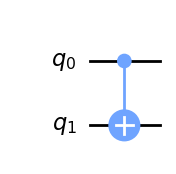

In [40]:
qc_cnot = QuantumCircuit(2)
qc_cnot.cx(0, 1) # We take the qubit 0 as control bit and qubit 1 as target qubit.

qc_cnot.draw('mpl')

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 
    
Having learned the basics of quantum circuts and quantum gates, create the circuit depcited in the figure below. Note that the order of your gate sequence matters. 
    
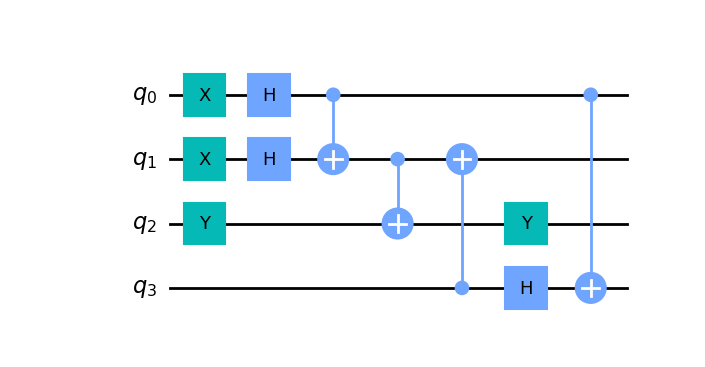
    
</div>


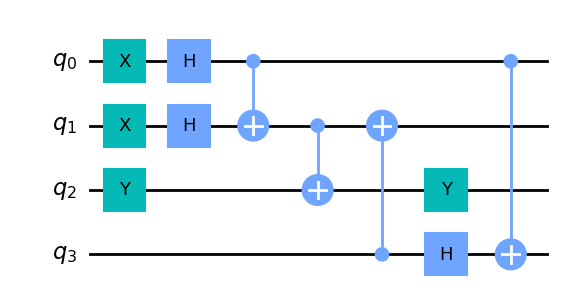

In [69]:
def ex_1():
    ### Write Your Code Below Here ###
    qc_1 = QuantumCircuit(4)
    
    qc_1.x([0,1])
    qc_1.h([0,1])
    qc_1.y(2)
    qc_1.cx(0,1)
    qc_1.cx(1,2)
    qc_1.cx(3,1)
    qc_1.y(2)
    qc_1.h(3)
    qc_1.cx(0,3)
    
    return qc_1

qc_1 = ex_1()
qc_1.draw('mpl')

<a id="Entanglements"></a>
## 2. Let's Create Entanglements! (Hello World of Quantum Computing)

Entanglement is the powerful quantum mechanical phenomena that makes quantum computing both unique and beautiful! Without it quantum computing would not be possible. When two or more qubits are entangled, their individual states cannot be described independently. In fact, measuring the state of one particle instantly determines the state of the other, regardless of the distance between them. This phenomenon has been called "spooky action at a distance" by Albert Einstein.

Measuring only one qubit of an entangled state will yield random results. However, when comparing the measurements of both qubits, one will find correlation. Knowing that, it is possible to measure only one state and conclude the other state. Considering two qubits, the entangled states are known as Bell States and can be written as following: 

$$\vert \Phi^\pm \rangle = \frac{1}{\sqrt{2}}(\vert 00 \rangle \pm \vert 11 \rangle)$$
$$\vert \Psi^\pm \rangle = \frac{1}{\sqrt{2}}(\vert 01 \rangle \pm \vert 10 \rangle)$$






<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Create the first Bell State using the quantum gates you learned in section 1. The first Bell State looks like this:
    $$\vert \Phi^+ \rangle = \frac{1}{\sqrt{2}}(\vert 00 \rangle + \vert 11 \rangle)$$

*(Hint: The Bell State equation suggests that when measuring your qubits, they will either both be in the state $|0\rangle$  or both in the state $|1\rangle$. Consider using $CNOT$ and $H$ Gate to achieve this. The [Quantum Composer](https://quantum.ibm.com/composer/files/new) may help you.)*
</div>

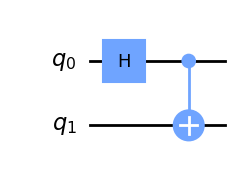

In [71]:
def create_bell():
    ### Write Your Code Below Here ###
    qc_bell = QuantumCircuit(2)
    qc_bell.h(0)
    qc_bell.cx(0,1)
    
    return qc_bell

qc_bell = create_bell()
qc_bell.draw('mpl')

Now let's plot the statevector, measure the qubits and get the quasi distributions.

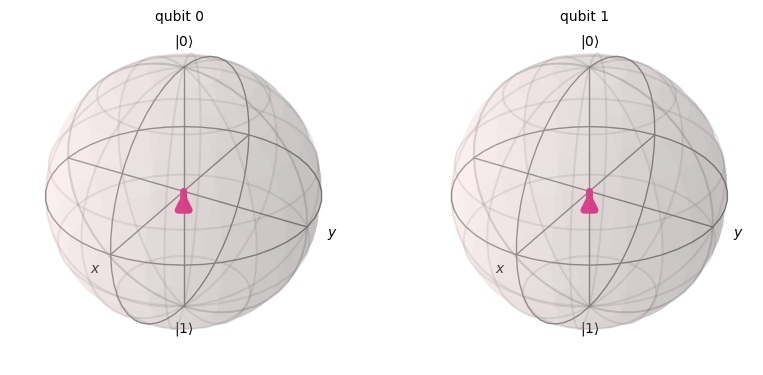

In [74]:
state_bell = statevector_backend.run(qc_bell).result().get_statevector()
plot_bloch_multivector(state_bell)

If you get two empty bloch spheres, don't worry. This is not a bug but a feauture of quantum mechanics! As described earlier, the entangled states cannot be written as two seperate qubit states. This means, an entangled stated cannot be represented on the bloch sphere. You did everything correctly :)

{'11': 498, '00': 526}


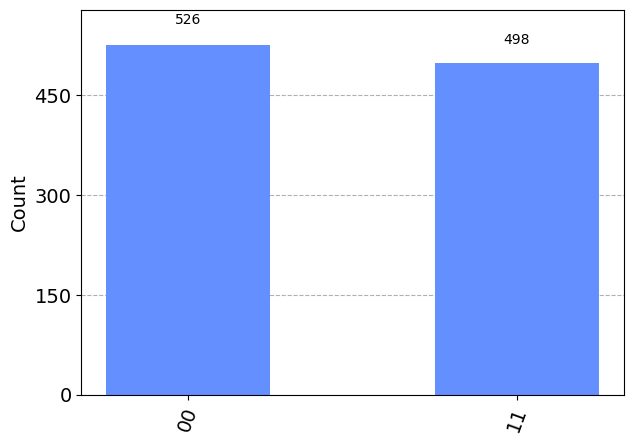

In [75]:
qc_bell.measure_all() # measuring the qubits 
counts = sim_backend.run(qc_bell,shots=1024).result().get_counts() # we need to perform multiple measurements, shots determine how often we measure
print(counts)
plot_histogram(counts)

Now we can extend the entanglement of two qubits to multiple qubits. These states are known as GHZ states, short for Greenberger-Horne-Zeilinger states. They are named after the physicists Daniel Greenberger, Michael Horne, and Anton Zeilinger, who introduced the concept.</p>
The canonical GHZ state for \(n\) qubits is defined as:</p>

$$|\text{GHZ}\rangle = \frac{1}{\sqrt{2}} (|00\ldots0\rangle + |11\ldots1\rangle)$$


<a id="exercise3"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 3:</b> 

Now create a GHZ state with 8 qubits. The state would look like this:
    $$|\text{GHZ}\rangle = \frac{1}{\sqrt{2}} (|00000000\rangle + |11111111\rangle)$$
    
</div>

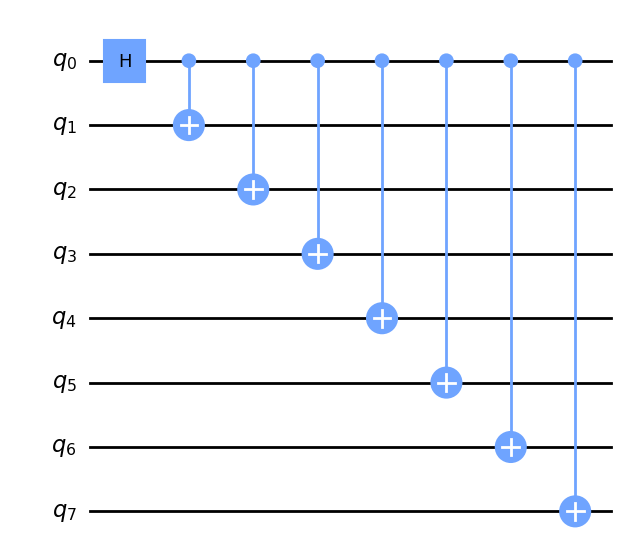

In [94]:
def create_ghz():
    ### Write Your Code Below Here ###
    qc_ghz = QuantumCircuit(8)

    qc_ghz.h(0)
    qc_ghz.cx(0,1)
    qc_ghz.cx(0,2)
    qc_ghz.cx(0,3)
    qc_ghz.cx(0,4)
    qc_ghz.cx(0,5)
    qc_ghz.cx(0,6)
    qc_ghz.cx(0,7)
    
    return qc_ghz

qc_ghz = create_ghz()
qc_ghz.draw('mpl')

{'00000000': 509, '11111111': 515}


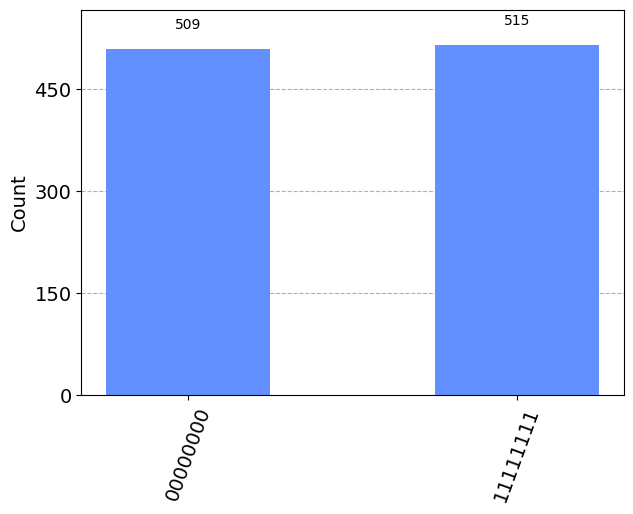

In [86]:
qc_ghz.measure_all() # measuring the qubits 
counts = sim_backend.run(qc_ghz,shots=1024).result().get_counts() # we need to perform multiple measurements, shots determine how often we measure
print(counts)
plot_histogram(counts)

<a id="CircuitDepth"></a>
## 3. Circuit Depth & Optimization

Now, that we learned how to create quantum ciruits and entangle qubits, let's think about optimising the performence of our circuits on real quantum devices. One important concept here is circuit depth and it refers to the length of the longest path from the circuit input to the circuit output, with each gate counting as a unit. Simply put, it is the minimum number of steps needed for quantum gates to be applied in parallel to execute a quantum circuit.

How can you exactly picture it? Well, you can simply think of it as playing Tetris! As you can see in the example below you can rotate the circuit and let the gates fall as far as possible. The number of layers is then your circuit depth. That would be 9 for our example.

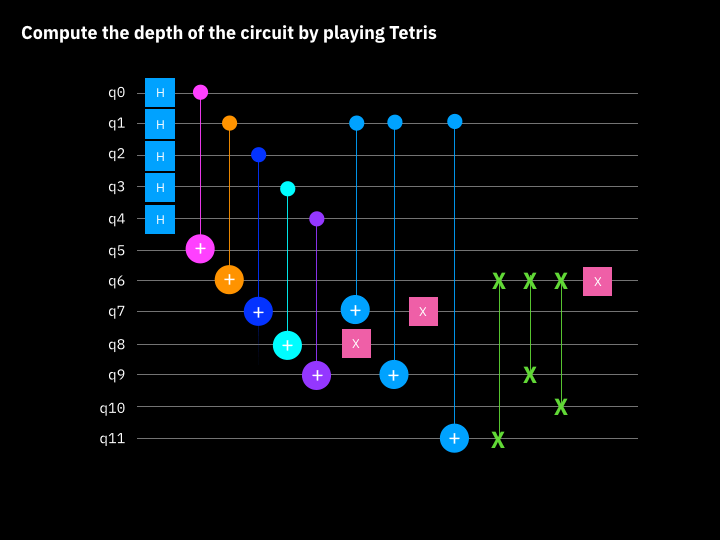

How can you compute the circuit depth? There’s simply a built-in function in Qiskit that returns the circuit depth of your given quantum circuit:

`QuantumCircuit.depth()`

### Why does it matter?

Now you may ask why is it a thing at all. How does that even relate to running a circuit on a real quantum computer more efficiently? The short answer is to avoid noise errors. Today’s devices are quite noisy and the deeper your quantum circuit, the higher the probability of an error occurring when executing it. So, shallow quantum circuits are less susceptible to noise errors and are therefore better!

This gets even more clear when you look at how a quantum circuit exactly runs on an actual quantum device. For example, to do this on IBM’s quantum computers, your circuit needs to be transpiled. What does that mean? It simply means you need to modify your circuit entirely to match the topology of a specific quantum device. Sounds complicated? Well, you don’t need to worry about that at all, we’re lucky that Qiskit has again a built-in function to do this job for us. You can read all about it **[here](https://docs.quantum.ibm.com/api/qiskit/transpiler)**.

The main takeaway for us is that the transpiled circuit looks different than the original one and it definitely has a larger circuit depth. More reason to ensure that the depth of our original circuit is minimised!



<a id="exercise4"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4:</b> 
    
 Compute the depth of your GHZ-circuit from exercise 3. Note to rerun the cell from exercise 3 before computing the depth to remove the measurements.
    
</div>


In [98]:
def get_circuit_depth():
    ### Write Your Code Below Here ###
    circuit_depth = qc_ghz.depth()
    
    return circuit_depth
    
circuit_depth = get_circuit_depth()
print("Circuit depth: ", circuit_depth)


Circuit depth:  8


Congratulations you made it! You now know all the basics to start your quantum journey! Keep it up and try the last eexercise if you fancy. Best of luck!

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 5 (Challenge):</b> 
Now minimise your circuit depth as much as possible. What is the minimum circuit depth you can get for an 8-qubit GHZ state? How does your strategy scale for higher GHZ states?

*(Hint: Think about using parallel gate execution and asymptotic complexity. Or simply play tetris! Note if you have single-qubit gates acting in parallel on different qubits, they can fall into the same layer. However, if you have various single-qubit gates acting on the same qubit, you cannot have them in the same layer. Similarly, for multi-qubit gates such as cNOT, as long as the control- and target bits of the subsequent gates don’t overlap, they can fall into the same layer, otherwise, you need more layers.)*
    
</div>

Circuit depth: 4


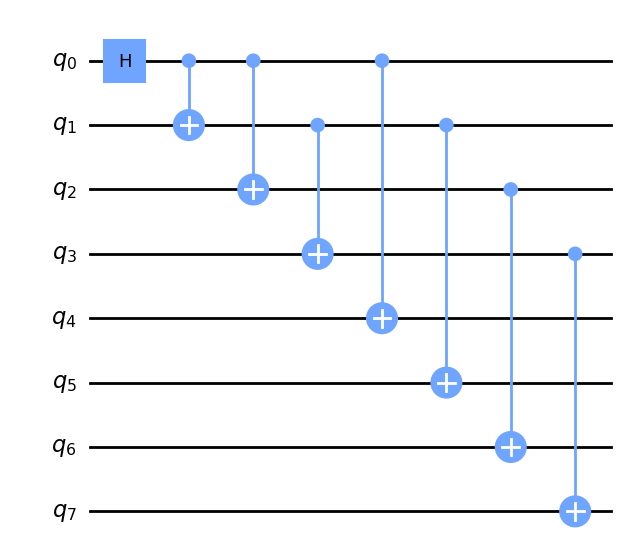

In [101]:
def get_optimised_ghz():
    ### Write Your Code Below Here ###
    qc_optghz = QuantumCircuit(8)
    
    qc_optghz.h(0)

    qc_optghz.cx(0, 1)

    qc_optghz.cx(0, 2)
    qc_optghz.cx(1, 3)

    qc_optghz.cx(0, 4)
    qc_optghz.cx(1, 5)
    qc_optghz.cx(2, 6)
    qc_optghz.cx(3, 7)
    
    return qc_optghz

qc_optghz = get_optimised_ghz()
print('Circuit depth:', qc_optghz.depth())
qc_optghz.draw('mpl')
    

You can read a summary of this lab including the code and further links [here](https://betterprogramming.pub/playing-tetris-with-quantum-circuits-c3aa282589f0). Finally, following our optimization journey, that's how our layers look like, where (a) depicts the basic ghz circuit and (b) our optimized solution:
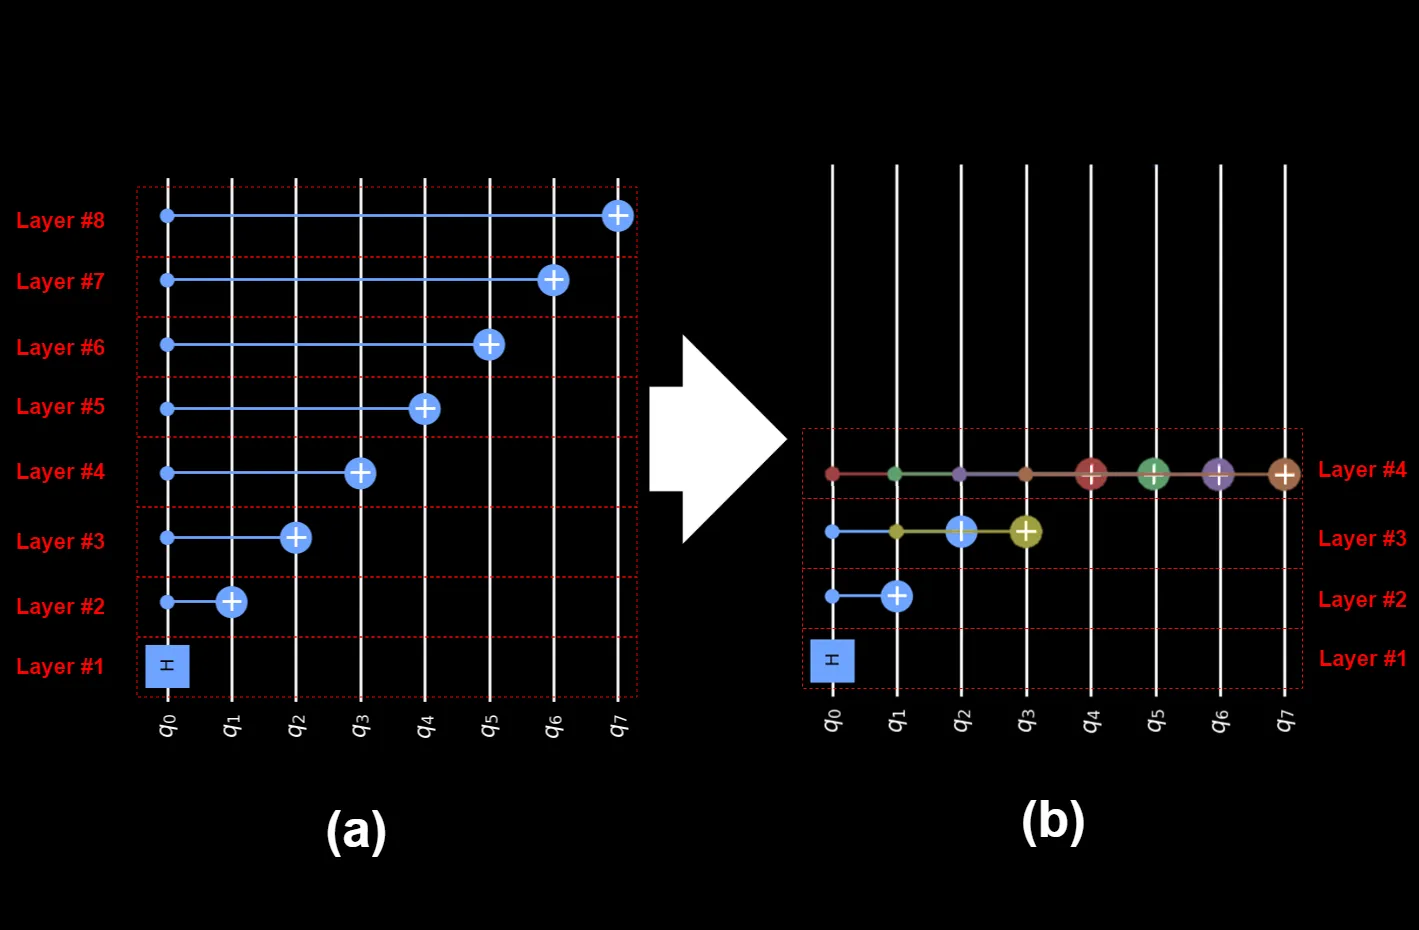

## Stay Curious!
If you are interested in diving deeper with quantum computing, have a look at [IBM Quantum Learning Platform](https://learning.quantum.ibm.com/). You can run your circuit on a real quantum device following the documentation [here](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-run_job). It's free and super easy! Stay up-to-date with Qiskit events [here](https://qiskit.org/events) and If you have any further questions feel free to reach out to me on [zina.efchary@ibm.com](zina.efchary@ibm.com). All the best and stay curious :)